In [ ]:
! pip install langchain-mcp-adapters langgraph "langchain[anthropic]" "langchain[openai]" langgraph-swarm httpx markdownify

## Swarm Researcher Example 

In [2]:
from prompts import planner_prompt, researcher_prompt
from utils import fetch_doc, print_stream

In [11]:
# Imports
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

# Chat model (OpenAI)
model = init_chat_model(model="gpt-4o", model_provider="openai")

# Reasoning model (Anthropic)
model = init_chat_model(
    model="claude-3-7-sonnet-latest",
    model_provider="anthropic",
    max_tokens=20_000,
    thinking={"type": "enabled", "budget_tokens": 16_000},
)

# Handoff tools
transfer_to_planner_agent = create_handoff_tool(
    agent_name="planner_agent",
    description="Transfer the user to the planner_agent for clarifying questions related to the user's request.",
)
transfer_to_researcher_agent = create_handoff_tool(
    agent_name="researcher_agent",
    description="Transfer the user to the researcher_agent to perform research and implement the solution to the user's request.",
)

# LLMS.txt
llms_txt = "LangGraph:https://langchain-ai.github.io/langgraph/llms.txt"
num_urls = 3
planner_prompt_formatted = planner_prompt.format(llms_txt=llms_txt, num_urls=num_urls)

In [12]:
from langgraph.checkpoint.memory import InMemorySaver

# Planner agent
planner_agent = create_react_agent(
    model,
    prompt=planner_prompt_formatted,
    tools=[fetch_doc, transfer_to_researcher_agent],
    name="planner_agent",
)

# Researcher agent
researcher_agent = create_react_agent(
    model,
    prompt=researcher_prompt,
    tools=[fetch_doc, transfer_to_planner_agent],
    name="researcher_agent",
)

# Swarm
checkpointer = InMemorySaver()
agent_swarm = create_swarm(
    [planner_agent, researcher_agent], default_active_agent="planner_agent"
)
app = agent_swarm.compile(checkpointer=checkpointer)

# Input
request = "Create a LangGraph application that is a prompt chain: it takes a topic from a user, generates a joke, and checks if the joke has a punchline."
config = {"configurable": {"thread_id": "1"}}
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": request}]}, config, subgraphs=True
    )
)

Namespace '('planner_agent:eb54a055-5558-8173-bdfe-1354f4af9d59',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: planner_agent

[{'signature': 'ErUBCkYIARgCIkC6WpscEupmQ2damyQ0uywIS1Q8cT2Xz3ItLScIVCcwBDDWDn06f2B3dje0yfotuN7ASTQcVF6J73il2P7D+qsVEgyzWzL2LuUcj55xblYaDH+THpsc+4/oaq1cuCIwagfMjqcspGi8154nyX9f6suawXEePc+Rnbj5ie9IuVoMSEU+sx8kLI+l0xN9CMUXKh095N9npEQOXSPmpohSjQA+UuMY7xi1/nYdo7hiTA==', 'thinking': 'The user wants to create a LangGraph application that:\n1. Takes a topic from a user\n2. Generates a joke based on that topic\n3. Checks if the joke has a punchline\n\nTo help implement this, I should first understand LangGraph better by fetching the documentation provided in the llms.txt file. Then I can formulate a plan for implementation.\n\nLet me first fetch the documentation:', 'type': 'thinking'}, {'text': "I'll help you create a LangGraph application for generating and validating jokes. First, let me review the 

Namespace '('planner_agent:07c7e919-0b27-f012-f663-adbf90464fae',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: planner_agent

[{'signature': 'ErUBCkYIARgCIkCzcDG8omno4rS3DhnIJLYUf/AUqY3IBoYv+oeAsNMXH+d2GuTHDqYSQJH6AahN5cxPENVzkbx4Ge7PmOeTAFFXEgxAkOH3vUQTThx9a7AaDFXn+zw8r4Ex3ChCgSIwkyZzH+IlvmIgWUUUmE0n2zDmNuWmFLr9XOB1XM9Q79FpHrA+04q6qGnURqMbvItLKh24kfCLQpu68yWeL1SCqiRhE4+G8UZ3YGWKXQnlBg==', 'thinking': 'Thanks for the clarifications. Here\'s my understanding of the project scope:\n\n1. User will provide a topic as input\n2. The application will generate a joke with a clear "setup:" and "punchline:" format\n3. This will be a simple Python script without UI or deployment\n4. The application will use OpenAI\'s models\n5. The final output can be a formatted string\n\nNow, I\'ll identify the most relevant URLs from the LangGraph documentation that will help with implementing this project:\n\n1. **[How to create a sequence o
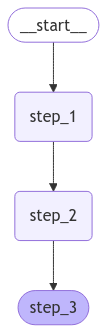
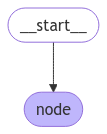

In [13]:
request = "1. User will pass a topic. 2. Format the joke with 'setup:' and 'punchline:' 3. Just  py script. No UI or deployment. 4. Use OpenAI. 5. Format can be a string."
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": request}]}, config, subgraphs=True
    )
)

### Traces 

Example planning trace - 

https://smith.langchain.com/public/7a428dfc-b8b8-4e28-bc05-9508a848082c/r

Example researcher trace - 

https://smith.langchain.com/public/1c9d0e28-56c4-4241-922b-afd614464edd/r

### Test Code 

In [7]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict


# Define state schema for our joke generator
class State(TypedDict):
    topic: str  # The topic provided by the user
    joke: str  # The generated joke
    has_punchline: bool  # Whether the joke has a punchline


# Create the nodes for our graph
def generate_joke(state: State):
    """Generate a joke with a punchline based on the provided topic."""
    # Initialize the LLM
    llm = ChatOpenAI(model="gpt-3.5-turbo")

    # Create a prompt that explicitly asks for a setup followed by a punchline
    prompt = f"Create a joke about {state['topic']}. Format it with a setup followed by 'punchline:' and then the actual punchline."

    # Generate the joke
    response = llm.invoke([HumanMessage(content=prompt)])

    # Return the joke
    return {"joke": response.content}


def check_punchline(state: State):
    """Check if the joke contains the word 'punchline'."""
    # Check if the joke contains the word 'punchline'
    if "punchline" in state["joke"].lower():
        return {"has_punchline": True}
    else:
        return {"has_punchline": False}


# Define conditional edge decision function
def decide_next_step(state: State):
    """Decide whether to end the process."""
    if state["has_punchline"]:
        return "end"
    else:
        # If we were to handle cases without punchlines, we'd route to a fix node
        # But per requirements, we'll just end without feedback
        return "end"


# Build the graph
def build_graph():
    # Create a graph with the defined state schema
    graph = StateGraph(State)

    # Add nodes
    graph.add_node("generate_joke", generate_joke)
    graph.add_node("check_punchline", check_punchline)

    # Add edges
    graph.add_edge(START, "generate_joke")
    graph.add_edge("generate_joke", "check_punchline")
    graph.add_conditional_edges("check_punchline", decide_next_step, {"end": END})

    # Compile the graph
    return graph.compile()


joke_graph = build_graph()

# Invoke the graph with the provided topic
result = joke_graph.invoke({"topic": "cats"})

In [8]:
result

{'topic': 'cats',
 'joke': 'Why are cats bad storytellers?\n\nPunchline: Because they always paws in the middle of the sentence.',
 'has_punchline': True}